In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import PCLinearClassifier
from pclib.optim.train import train
# from pclib.utils.functional import vfe
from pclib.utils.plot import plot_stats
from pclib.utils.eval import track_vfe, accuracy
from customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
# ])
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.0
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

In [4]:
seed = 42
torch.manual_seed(seed)
model_name = "mnist_pclinear"

# Model parameters
HIDDEN_DIMS = [256, 256]
SYMMETRIC = True
BIAS = True
STEPS = 20
GAMMA = 0.1

model = PCLinearClassifier(INPUT_SHAPE, NUM_CLASSES, HIDDEN_DIMS, bias=BIAS, symmetric=SYMMETRIC, steps=STEPS, gamma=GAMMA).to(device)
step = 0
stats = None

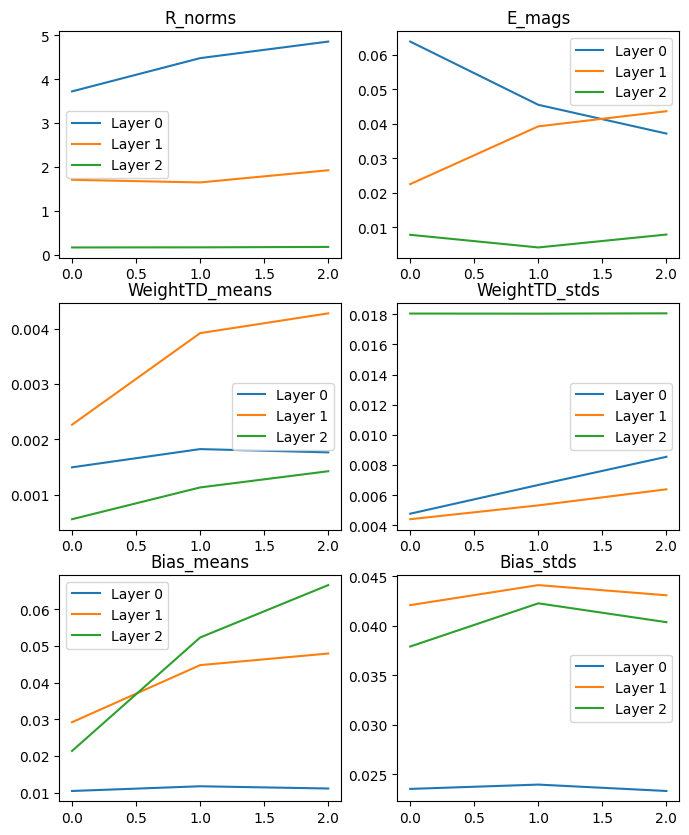

In [5]:
# Train Loop
LEARNING_RATE = 0.01
NUM_EPOCHS = 3
BATCH_SIZE = 1024
REG_COEFF = 1e-2
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
)

plot_stats(stats, model, SYMMETRIC, BIAS)

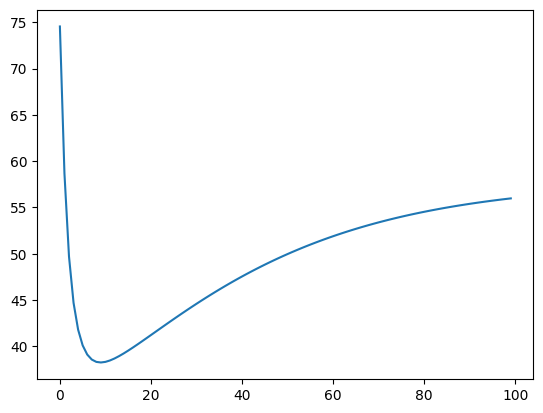

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = torch.nn.functional.one_hot(y, NUM_CLASSES).float()
track_vfe(model, x, y)

Max accuracy: 0.36511666666666664


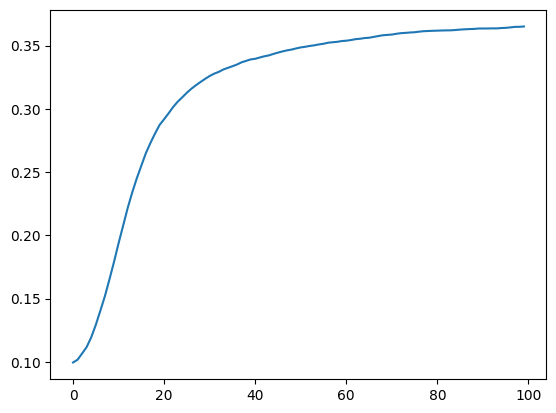

In [7]:
accuracy(model, train_dataset)